In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.autograd import Function
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [2]:
use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda:
    device = torch.device('cuda:0')
    print('Training on GPU...')
else:
    device = torch.device('cpu')
    print('Training on CPU...')

CUDA available: True
Training on GPU...


In [3]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [4]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

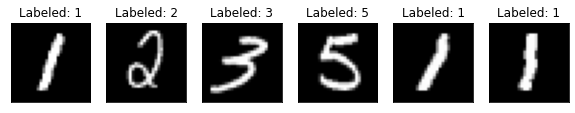

In [5]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [6]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [7]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z]).to(device)
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]).to(device) - torch.tensor([expectation_left]).to(device)
            gradients.append(gradient)
        
        gradients = torch.tensor([gradients]).to(device)
        gradients = torch.transpose(gradients, 0, 1)

        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x1 = self.hybrid1(x[0][0].reshape(1,-1))
        x2 = self.hybrid2(x[0][1].reshape(1,-1))
        x = torch.cat((x1,x2),-1).float()
        x = self.fc3(x)
        return x

In [9]:
def train(model, opimizer, loss_func, train_loader):
    model.train()

    total_loss = []
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    #loss_list.append(sum(total_loss)/len(total_loss))

    return sum(total_loss)/len(total_loss)

In [10]:
def validation(model, test_loader):
    model.eval()
    with torch.no_grad():
        total_loss = []
        correct = 0
        for batch_idx, (data, target) in tqdm(enumerate(test_loader)):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target.cuda())
            total_loss.append(loss.item())
    loss = sum(total_loss) / len(total_loss)
    acc = correct / len(test_loader) * 100

    return loss, acc

In [12]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
train_loss_list = []
test_loss_list = []
acc_list = []
epochs = 5
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    train_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    acc_list.append(acc)
    test_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

60000it [17:32, 56.99it/s]
10000it [00:53, 188.26it/s]


Training [20%]	train_Loss: 1.2568	test_acc: 69.3%


60000it [17:34, 56.88it/s]
10000it [01:10, 142.25it/s]


Training [40%]	train_Loss: 0.8152	test_acc: 70.0%


60000it [16:45, 59.69it/s]
10000it [00:44, 223.65it/s]


Training [60%]	train_Loss: 0.7068	test_acc: 76.7%


60000it [14:07, 70.76it/s]
10000it [00:48, 206.34it/s]


Training [80%]	train_Loss: 0.6191	test_acc: 80.9%


60000it [14:30, 68.90it/s]
10000it [00:47, 209.62it/s]

Training [100%]	train_Loss: 0.5509	test_acc: 90.1%


Text(0, 0.5, 'Neg Log Likelihood Loss')

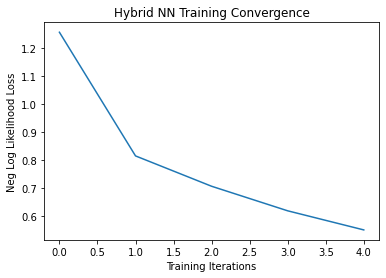

In [13]:
plt.plot(train_loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [14]:
class SNet(nn.Module):
    def __init__(self):
        super(SNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        return x

In [15]:
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        return x

In [16]:
model = SNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
Strain_loss_list = []
Stest_loss_list = []
Sacc_list = []
epochs = 5
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    Strain_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    Sacc_list.append(acc)
    Stest_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

60000it [02:14, 445.16it/s]
10000it [00:07, 1349.49it/s]


Training [20%]	train_Loss: 1.3508	test_acc: 50.4%


60000it [02:12, 452.17it/s]
10000it [00:07, 1351.49it/s]


Training [40%]	train_Loss: 0.9559	test_acc: 75.8%


60000it [02:12, 453.58it/s]
10000it [00:07, 1335.30it/s]


Training [60%]	train_Loss: 0.7607	test_acc: 84.8%


60000it [02:12, 452.45it/s]
10000it [00:07, 1334.23it/s]


Training [80%]	train_Loss: 0.6396	test_acc: 86.7%


60000it [02:15, 444.15it/s]
10000it [00:07, 1334.58it/s]

Training [100%]	train_Loss: 0.5554	test_acc: 86.3%


Text(0, 0.5, 'Loss')

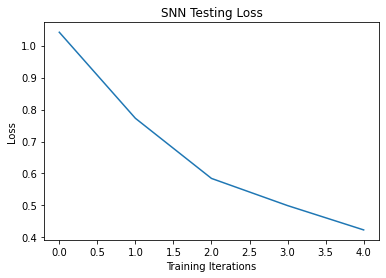

In [17]:
plt.plot(Stest_loss_list)
plt.title('SNN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

In [19]:
model = TNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
Ttrain_loss_list = []
Ttest_loss_list = []
Tacc_list = []
epochs = 5
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    Ttrain_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    Tacc_list.append(acc)
    Ttest_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

60000it [02:12, 451.38it/s]
10000it [00:07, 1323.83it/s]


Training [20%]	train_Loss: 1.1681	test_acc: 79.8%


60000it [02:13, 448.86it/s]
10000it [00:07, 1324.36it/s]


Training [40%]	train_Loss: 0.7071	test_acc: 85.4%


60000it [02:15, 444.21it/s]
10000it [00:07, 1310.76it/s]


Training [60%]	train_Loss: 0.5612	test_acc: 85.4%


60000it [02:15, 442.53it/s]
10000it [00:07, 1299.47it/s]


Training [80%]	train_Loss: 0.4792	test_acc: 87.8%


60000it [02:15, 443.36it/s]
10000it [00:07, 1310.07it/s]

Training [100%]	train_Loss: 0.4485	test_acc: 93.2%


Text(0, 0.5, 'Loss')

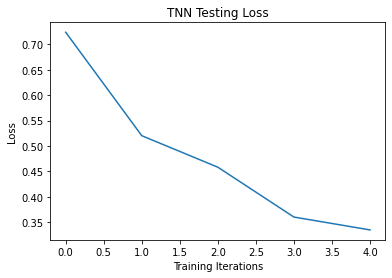

In [20]:
plt.plot(Ttest_loss_list)
plt.title('TNN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

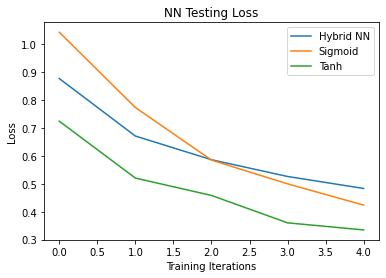

In [21]:
plt.plot(test_loss_list, label='Hybrid NN')
plt.plot(Stest_loss_list, label='Sigmoid')
plt.plot(Ttest_loss_list, label='Tanh')
plt.legend()
plt.title('NN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

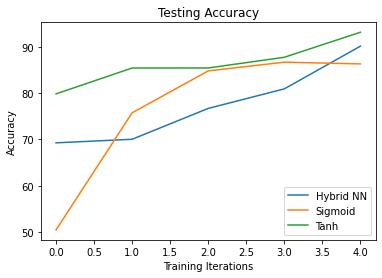

In [22]:
plt.plot(acc_list, label='Hybrid NN')
plt.plot(Sacc_list, label='Sigmoid')
plt.plot(Tacc_list, label='Tanh')
plt.legend()
plt.title('Testing Accuracy')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')